<a href="https://www.kaggle.com/code/drkaggle22/toxic-comments-classification-tf-idf-nltk?scriptVersionId=177472932" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [2]:
df_train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip', index_col='id')

df_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip', index_col='id')

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
df = pd.concat([df_train, df_test])

In [5]:
df_train['comment_text'] = df_train['comment_text'].str.lower()
df_test['comment_text'] = df_test['comment_text'].str.lower()

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [7]:
import re

def remove_special_characters(text):
    text = re.sub(r'http\S+', ' ', text )
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\bhttps?://[a-zA-Z0-9-]+(?:\.[a-zA-Z0-9-]+)+\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d', ' ', text)  # Corrected line
    text= re.sub(r'[\u4e00-\u9fff]+', ' ', text)
    return text

df_train['comment_text'] = df_train['comment_text'].apply(remove_special_characters)
df_test['comment_text'] = df_test['comment_text'].apply(remove_special_characters)

print(df_train['comment_text'].head(100))


id
0000997932d777bf    explanation why the edits made under my userna...
000103f0d9cfb60f    d aww he matches this background colour i m se...
000113f07ec002fd    hey man i m really not trying to edit war it s...
0001b41b1c6bb37e    more i can t make any real suggestions on impr...
0001d958c54c6e35    you sir are my hero any chance you remember wh...
00025465d4725e87    congratulations from me as well use the tools ...
0002bcb3da6cb337         cocksucker before you piss around on my work
00031b1e95af7921    your vandalism to the matt shirvington article...
00037261f536c51d    sorry if the word nonsense was offensive to yo...
00040093b2687caa    alignment on this subject and which are contra...
0005300084f90edc    fair use rationale for image wonju jpg thanks ...
00054a5e18b50dd4    bbq be a man and lets discuss it maybe over th...
0005c987bdfc9d4b    hey what is it talk what is it an exclusive gr...
0006f16e4e9f292e    before you start throwing accusations and warn...
00070ef96486d6f9 

In [8]:
from nltk import word_tokenize

df_train['word_tokens'] = df_train['comment_text'].apply(word_tokenize)
df_test['word_tokens'] = df_test['comment_text'].apply(word_tokenize)

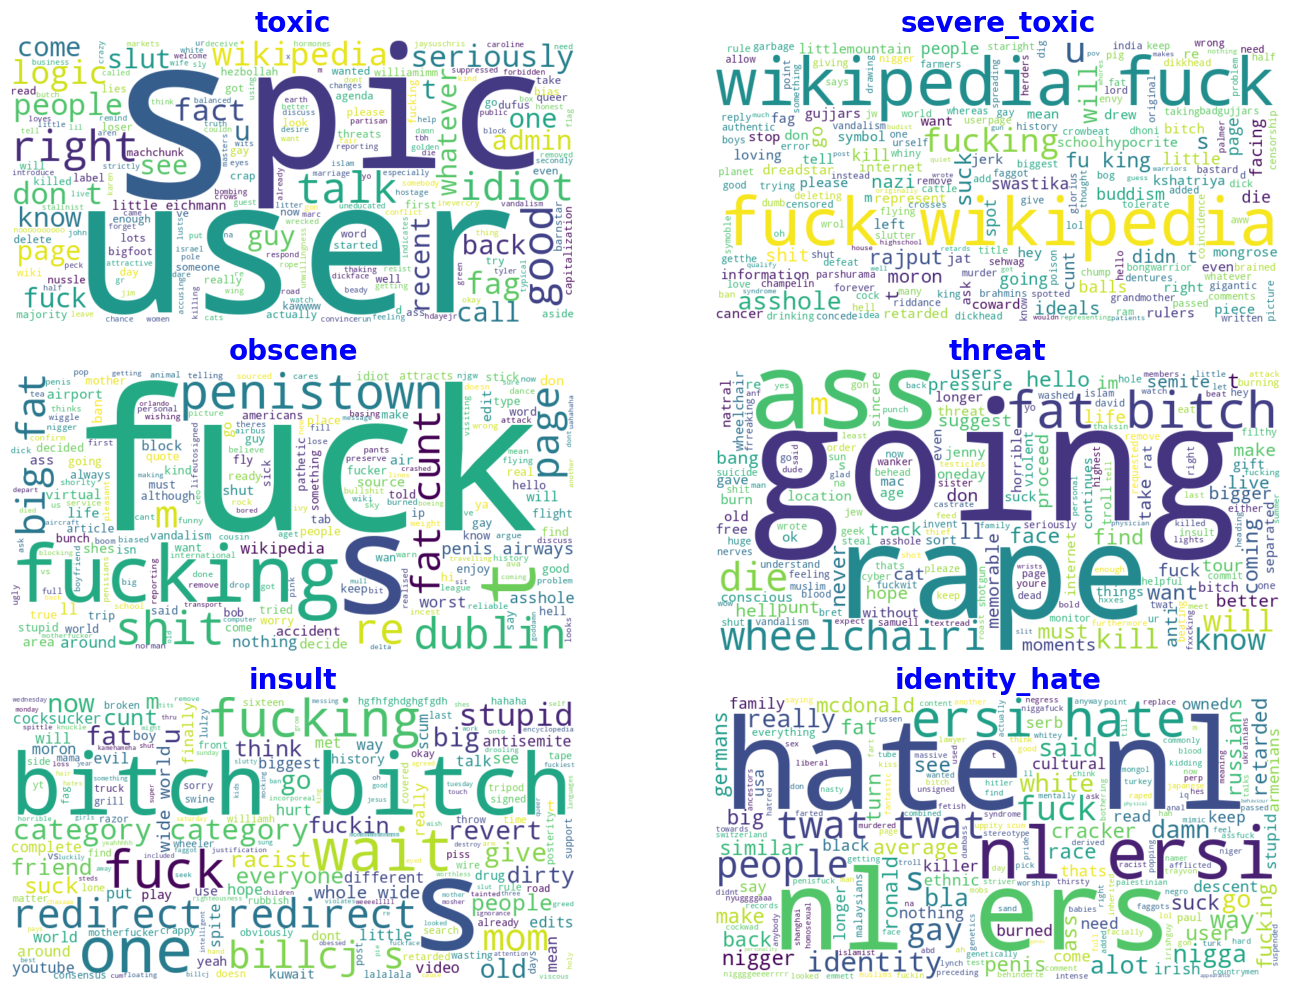

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Classes
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

def generate_wordcloud(tokens):
    flat_tokens = []
    for sublist in tokens:
        for token in sublist:
            flat_tokens.append(token)
    text = ' '.join(flat_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    return wordcloud

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

for i, class_name in enumerate(classes):
    row, col = np.unravel_index(i,(3, 2))
    
    class_tokens = df_train[df_train[class_name] == 1]['word_tokens']
    selected_tokens = class_tokens.sample(n=25)

    wordcloud = generate_wordcloud(selected_tokens)

    axs[row, col].imshow(wordcloud, interpolation='bilinear')
    axs[row, col].set_title(class_name, fontsize=20, fontweight='bold', color='blue')  # Highlight and bold title
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df_train, train_size=0.8, random_state=42)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

# Define the TfidfVectorizer with specified parameters
vec = TfidfVectorizer(ngram_range=(1, 2), 
                      min_df=3, 
                      max_df=0.9, 
                      strip_accents='unicode', 
                      use_idf=1,
                      smooth_idf=1, 
                      sublinear_tf=1,
                      binary=1,
                      stop_words='english')
                      

# Transform the training, validation, and test data
trn_term_doc = vec.fit_transform(df_train['comment_text'])
val_term_doc = vec.transform(valid['comment_text'])
test_term_doc = vec.transform(df_test['comment_text'])


/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


In [12]:
x = trn_term_doc
val_x = val_term_doc

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [14]:
epsilon = 1e-9  # Define epsilon as a small positive constant


In [15]:
# Define a function to calculate the probability of each word given a specific class (toxic or non-toxic)
def probability(y_i, y):
    # Sum the occurrences of each word in comments labeled with y_i (1 for toxic, 0 for non-toxic)
    occurences = x[y == y_i].sum(0)
    # Add a smoothing factor of 1 to avoid division by zero and handle words not present in some classes
    return (occurences + 1) / ((y == y_i).sum() + 1)

In [16]:
def get_model(y):
    # Convert the target labels to a numpy array
    y = y.values
    # Calculate the log-ratio of probabilities of each word being toxic vs. non-toxic
    loga = np.log((probability(1, y) + epsilon) / (probability(0, y) + epsilon) )
    # Multiply the input features by the log-ratio to incorporate the information about word toxicity
    x_loga = x.multiply(loga)
    # Initialize a logistic regression model with specified hyperparameters
    model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100, random_state=42)
    # Fit the model to the modified input features and target labels
    return model.fit(x_loga, y), loga


In [17]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_labels = df_train.drop(['comment_text'], axis = 1)
valid_labels = valid.drop(['comment_text'], axis = 1)

In [18]:
  # Dictionary to store ROC AUC scores for each class
model = {}
ROC_AUC_Scores = {}
for i, col in enumerate(classes):
    print(col)

    # Train model for current class
    model_trained, loga = get_model(train_labels[col])
    model[col] = (model_trained, loga)
    # Make predictions on validation set
    preds = model_trained.predict(val_x.multiply(loga)).reshape(-1, 1)

    # Calculate ROC AUC score for current class and store it
    roc_auc = roc_auc_score(valid_labels[col], preds)
    ROC_AUC_Scores[col] = roc_auc
    # Print ROC AUC scores for each class
for col, roc_auc in ROC_AUC_Scores.items():
    print(f"ROC AUC for class: '{col}': {roc_auc}")

toxic
severe_toxic
obscene
threat
insult
identity_hate
ROC AUC for class: 'toxic': 0.882298818964349
ROC AUC for class: 'severe_toxic': 0.8593699620003561
ROC AUC for class: 'obscene': 0.9121859131542873
ROC AUC for class: 'threat': 0.9661534041186063
ROC AUC for class: 'insult': 0.8711052432334527
ROC AUC for class: 'identity_hate': 0.8808416950158198


In [19]:
preds = np.zeros((len(df_test), len(classes)))

for i, col in enumerate(classes):
    print(col)
    preds[:, i] = model[col][0].predict_proba(test_term_doc.multiply(model[col][1]))[:, 1]

toxic
severe_toxic
obscene
threat
insult
identity_hate


In [20]:
submid = pd.DataFrame({'id': df_test.index})  # Use index as 'id' column
submission = pd.concat([submid, pd.DataFrame(preds, columns=classes)], axis=1)
submission.to_csv('submission.csv', index=False)


In [21]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999950,0.077125,0.999502,0.005494,0.965543,0.186210
1,0000247867823ef7,0.005033,0.001199,0.003409,0.000412,0.005956,0.001228
2,00013b17ad220c46,0.012523,0.000839,0.004402,0.000413,0.006708,0.001066
3,00017563c3f7919a,0.004258,0.000925,0.003341,0.000551,0.003943,0.000840
4,00017695ad8997eb,0.026765,0.001160,0.005383,0.000411,0.008904,0.001018
